In [6]:
#Classification of MNIST dataset 
push!(LOAD_PATH, "/home/jberez/Projects/OptDigits/dockeropt20")

using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using IterTools #Only for plots, not for program
using Serialization
using BNN

include("dockeropt20/utils.jl");
include("dockeropt20/LoadData.jl");

┌ Info: Precompiling BNN [top-level]
└ @ Base loading.jl:1260


In [8]:
#Read Optdigits CSV
#using CSV
#using DataFrames

#test = CSV.read("dockeropt/optdigits.csv", DataFrame)
#y_total = Array(test[:,65]) .+ 1
#x_total = Array(test[:,1:64]);
#x_total = [Float64(i) for i in x_total]
x_total = deserialize("dockeropt20/optdigits_x.jld")
y_total = deserialize("dockeropt20/optdigits_y.jld")

#display(x_total[1:5,:])

dx = fit(ZScoreTransform, x_total, dims=2)
StatsBase.transform!(dx, x_total);

#display(x_total[1:5,:])

In [48]:
#Load Train and Test Sets

function balanced_set(x,y,n,c,seed=0)
    
    if seed != 0
        Random.seed!(seed)
    end
    
    shuffled_indices = shuffle(1:length(y))
    x = x[shuffled_indices,:]
    y = y[shuffled_indices]
    
    x_ordered = zeros(Float64,n*c,64)
    y_ordered = zeros(Int,n*c)
    for k=1:c
        labels = [i for i in 1:length(y) if y[i]==k]
        x_ordered[k*n-(n-1):k*n,:] = x[labels,:][1:n,:]
        y_ordered[k*n-(n-1):k*n] = y[labels][1:n]
    end
    return x_ordered, y_ordered
end

function reshape_x(x)
    n = size(x)[1]
    println(n)
    x_reshaped = zeros(Float64, 8, 8, n)
    for i=1:n
        test = reshape(x[i,:], (1,8,8))
        x_reshaped[:,:,i] = reshape(x[i,:], (8,8))
    end
    return x_reshaped
end;

#Load the OptDigits Data
num_samples = 10
num_classes = 10

x_train, y_train = balanced_set(x_total,y_total,num_samples,num_classes,1);
x_test, y_test = balanced_set(x_total,y_total,num_samples,num_classes,2);
x_full, y_full = balanced_set(x_total, y_total,200,num_classes,300);

In [49]:
#Prepare full test set

#Standardize x Data
dx = fit(ZScoreTransform, x_total, dims=2)
StatsBase.transform!(dx, x_total)
x_test, y_test = balanced_set(x_total,y_total,num_samples,num_classes,300)

#Load the OptDigits Data
num_samples = 100
num_classes = 10

#x_train, y_train = balanced_set(x_total,y_total,num_samples,num_classes,1);#Random seed 1 for train data
#x_test, y_test = balanced_set(x_total,y_total,num_samples,num_classes,300);#Random seed 2 for test data

#Get PCA Transform for x
x = transpose(x_train)

#########
dims = 20
#########

x_pca = fit(PCA,x,maxoutdim=dims)
xt = MultivariateStats.transform(x_pca,x)

#Testing PCA Transform
xz = MultivariateStats.transform(x_pca,transpose(x_test));

#Full PCA Transform
xf = MultivariateStats.transform(x_pca,transpose(x_full));

#One-Hot Encode Y
y = y_train
yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
#Test Set
yz = y_test
yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
#Full Test Set
yf = y_full
yft = Flux.onehotbatch(yf,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);

#x_total_pca = MultivariateStats.transform(x_pca,transpose(x_total));

In [20]:
#folder = "/Data/BostonLong/"
folder = "/Data/Opt20/"
traces = []
tests = [i for i=1:16]
#filename_pre = "trace"
filename_pre = "OPTtrace"
filename_end = "output.jld"

good_traces = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
#good_traces = [1,2,3,4]

for i in good_traces
    current_file = join([pwd(),folder,filename_pre,"$(tests[i])", filename_end])
    current_traces = deserialize(current_file)
    push!(traces,current_traces)
end;
chains = length(traces);

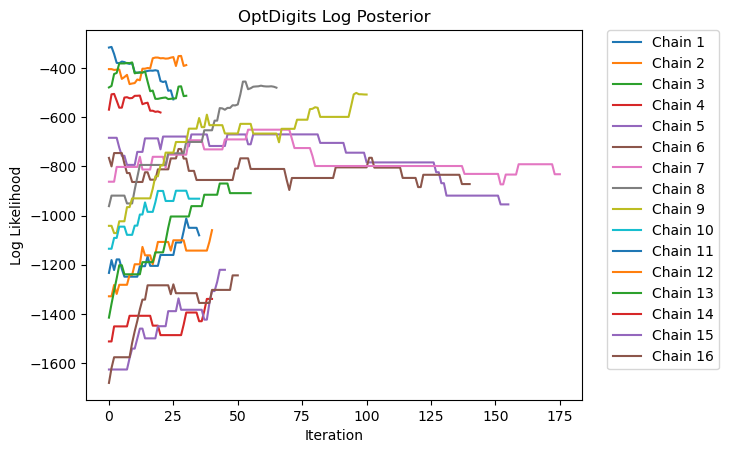

In [21]:
#Plot Log Posterior for Each Chain

for i=1:chains
    scores = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        scores[j] = get_score(trace)
    end
    plot(scores,label="Chain $i")
end
plt.title("OptDigits Log Posterior")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood");
#plt.ylim(-500,-100)

legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

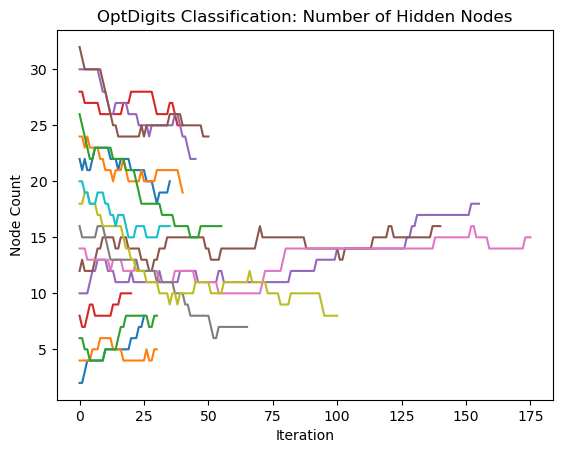

In [22]:
#Node Count Chart
for i=1:chains
    plot([trace[(:k,1)] for trace in traces[i]])
end
plt.title("OptDigits Classification: Number of Hidden Nodes")
plt.xlabel("Iteration")
plt.ylabel("Node Count");

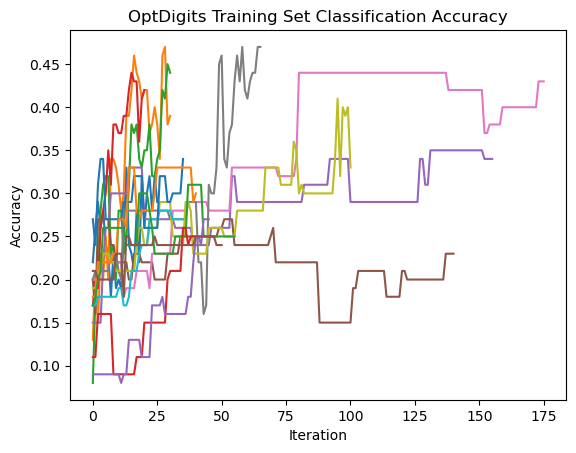

In [24]:
#Plot Training Accuracy
for v=1:chains
    active_traces = traces[v]
    accs = []
    dists = []
    for i = 1:length(active_traces)
        trace = active_traces[i]
        test_labels = G(xt,trace)
        results = label_output(test_labels)
        test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
        test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
        push!(accs,test_acc)
        push!(dists,test_dist)
    end
    plot(accs)
end

plt.title("OptDigits Training Set Classification Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

In [31]:
test_trace = traces[10][35]
test_labels = G(xt,test_trace)
results = label_output(test_labels)
sum([y_train[i] == results[i] for i=1:length(y_train)])

220

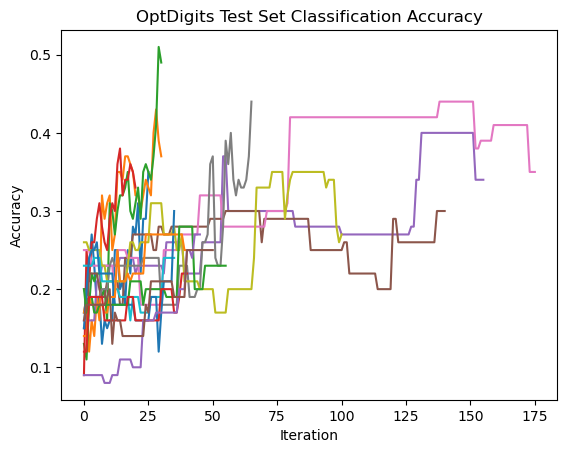

In [27]:
#Plot Test Accuracy
for v=1:chains
    active_traces = traces[v]
    accs = []
    dists = []
    for i = 1:length(active_traces)
        trace = active_traces[i]
        test_labels = G(xz,trace)
        results = label_output(test_labels)
        test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
        test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y_test)])
        push!(accs,test_acc)
        push!(dists,test_dist)
    end
    plot(accs)
end

plt.title("OptDigits Test Set Classification Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

In [50]:
#Marginalize Probabilities - Train Set
j = 1
c = 10
N = 100
total_count = sum([length(traces[i]) for i=1:chains])
targets = zeros(total_count-(chains*j),c,N)
for v=1:chains
    active_traces = traces[v]
    count = 1
    for i=j:length(active_traces)-j
        trace = active_traces[i]
        labels = G(xt,trace)
        targets[count,:,:] = labels
        count += 1
    end
end

sums = sum(targets,dims=1)[1,:,:]./(total_count)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])
println("Training set accuracy: $test_acc")

Training set accuracy: 47


In [51]:
#Marginalize Probabilities - Test Set
j = 1
c = 10
N = 100
total_count = sum([length(traces[i]) for i=1:chains])
targets = zeros(total_count-(chains*j),c,N)
for v=1:chains
    active_traces = traces[v]
    count = 1
    for i=j:length(active_traces)-j
        trace = active_traces[i]
        labels = G(xz,trace)
        targets[count,:,:] = labels
        count += 1
    end
end

sums = sum(targets,dims=1)[1,:,:]./(total_count)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y_test[i] == guesses[i] for i=1:length(y_test)])
println("Test set accuracy: $test_acc")

Test set accuracy: 46


In [52]:
#Marginalize Probabilities - Full Set
j = 1
c = 10
N = 1000
total_count = sum([length(traces[i]) for i=1:chains])
targets = zeros(total_count-(chains*j),c,length(y_full))
for v=1:chains
    active_traces = traces[v]
    count = 1
    for i=j:length(active_traces)-j
        trace = active_traces[i]
        labels = G(xf,trace)
        targets[count,:,:] = labels
        count += 1
    end
    print("$v.")
end
println("")
sums = sum(targets,dims=1)[1,:,:]./(total_count)
guesses = [findmax(sums[:,i])[2] for i=1:length(y_full)]
test_acc = sum([y_full[i] == guesses[i] for i=1:length(y_full)])/length(y_full)
println("Test set accuracy: $test_acc")

1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.Test set accuracy: 0.424


In [44]:
length(y_full)

2000

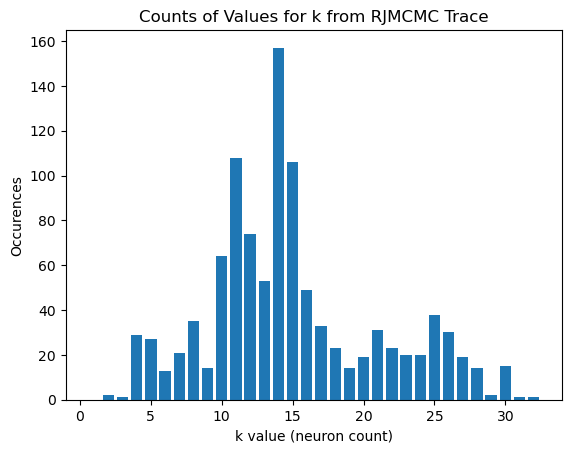

In [37]:
#Hidden Node Counts
k_list = [i for i in 1:32]

ls = [[traces[i][j][(:k,1)] for j=1:length(traces[i])] for i=1:chains]
ls = collect(Iterators.flatten(ls))

counts = [sum([k_list[ls[i]] == j for i in 1:length(ls)]) for j in k_list]
bar(k_list,counts)

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value (neuron count)")
plt.ylabel("Occurences");

In [56]:
#Acceptance Probability
#folder = "/Data/BostonLong/"
#folder = "/Data/BostonFour/"
folder = "/Data/Opt2/"

filename_pre = "OPT"
filename_endA = "AcceptanceA.jld"
filename_endW = "AcceptanceW.jld"

current_file = join([pwd(),folder,filename_pre,filename_endA])
across = deserialize(current_file)
current_file = join([pwd(),folder,filename_pre,filename_endW])
within = deserialize(current_file)

across_accs = [sum(i)/length(i) for i in across]
across_total = sum(collect(Iterators.flatten(across)))/length(collect(Iterators.flatten(across)))

within_accs = [sum(i)/length(i) for i in within]
within_total = sum(collect(Iterators.flatten(within)))/length(collect(Iterators.flatten(within)))
println("Across Accuracy: $across_total")
println("Within Accuracy: $within_total")

Across Accuracy: Any[]
Within Accuracy: Any[]


In [57]:
across

4-element Array{Array{Any,1},1}:
 [Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[]  …  Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[]]
 [Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[]  …  Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[]]
 [Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[]  …  Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[]]
 [Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[]  …  Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[], Any[]]